# RAFT



In [1]:
import os
os.environ['HTTP_PROXY'] = 'http://proxy.vmware.com:3128'
os.environ['HTTPS_PROXY'] = 'http://proxy.vmware.com:3128'

In [3]:
!git clone https://github.com/princeton-vl/RAFT.git

Cloning into 'RAFT'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 10.01 MiB | 9.08 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [1]:
cd RAFT

/home/jovyan/RAFT


Script download_models.sh does not work. So, download manually in browser from https://www.dropbox.com/s/4j4z58wuv8o0mfz and upload to the current location and unzip it.

Run the command: !python demo.py --model=models/raft-things.pth --path=demo-frames in notebook cell does not work. There are some issues:

- change display images from using cv2 to matplotlib.pyplot
- paste the code in demo.py into a cell, running command does not dispaly pictures, only display 9 "Figure(640x480)"
- transfer the command line arguments by defining a class with inherits from argparse.Namespace
- some other tweaks as shown below

In [2]:
%matplotlib inline
%matplotlib widget

In [3]:
pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 28.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 22.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.7 kB/s eta 0:00:0000:0100:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 21.2 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


/home/venv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


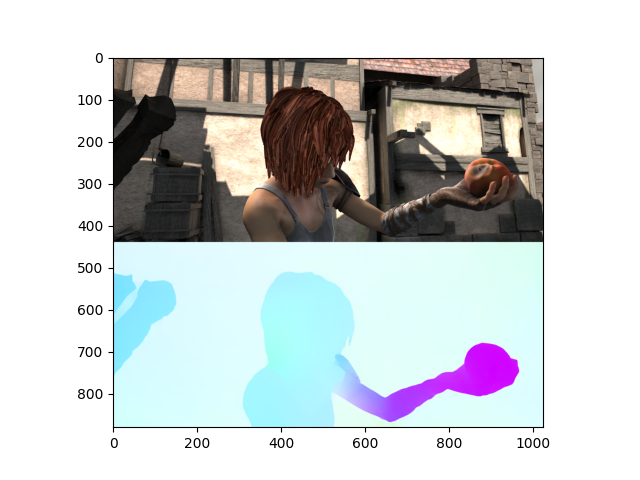

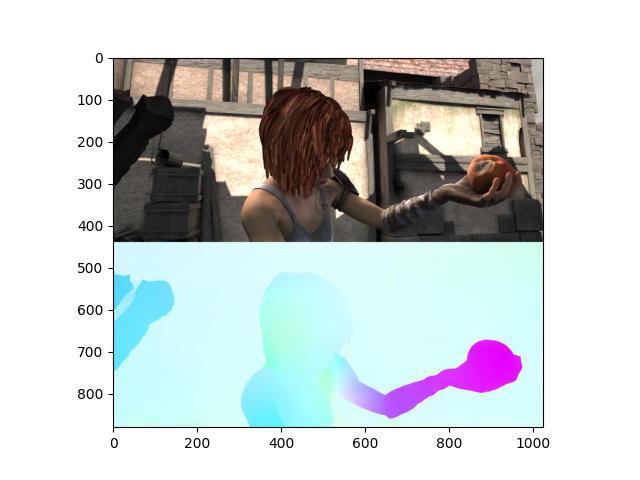

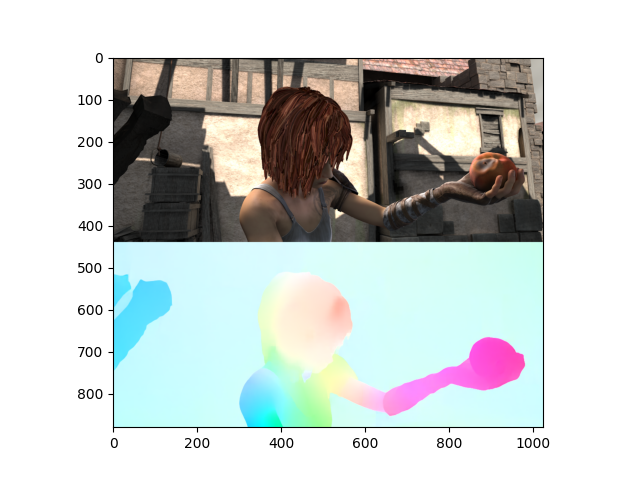

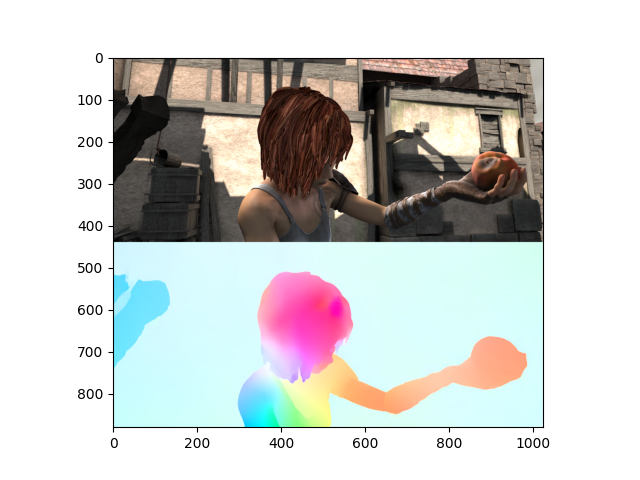

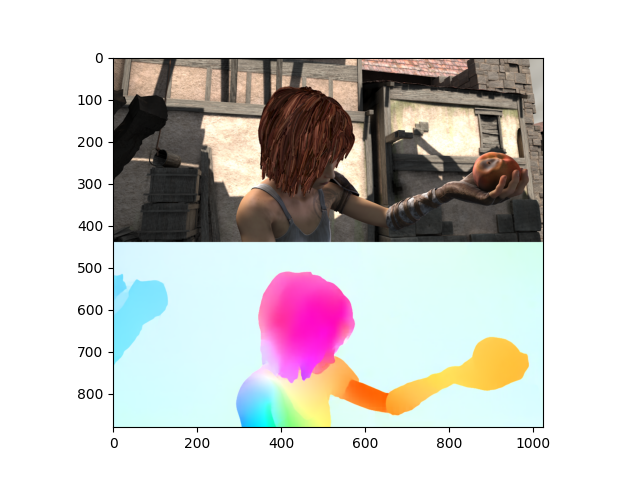

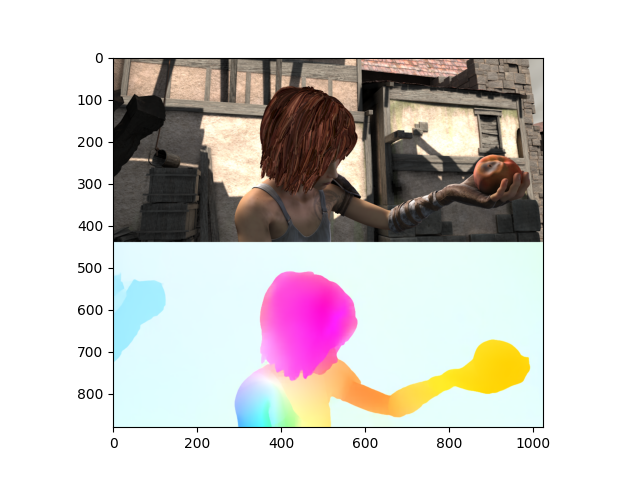

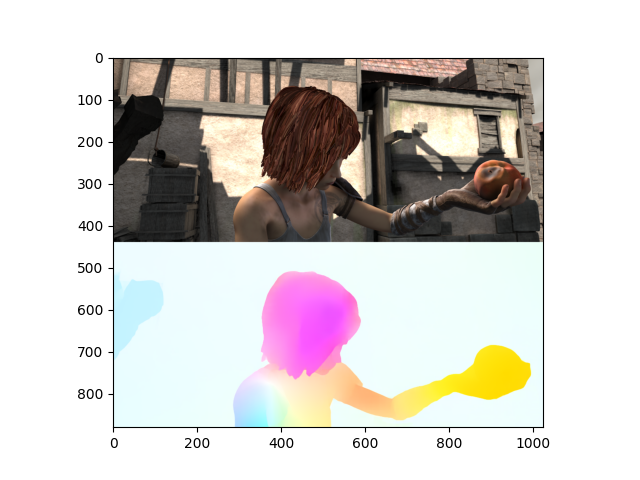

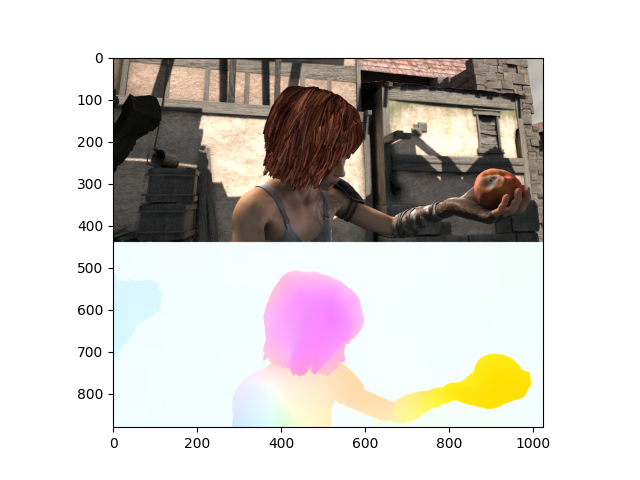

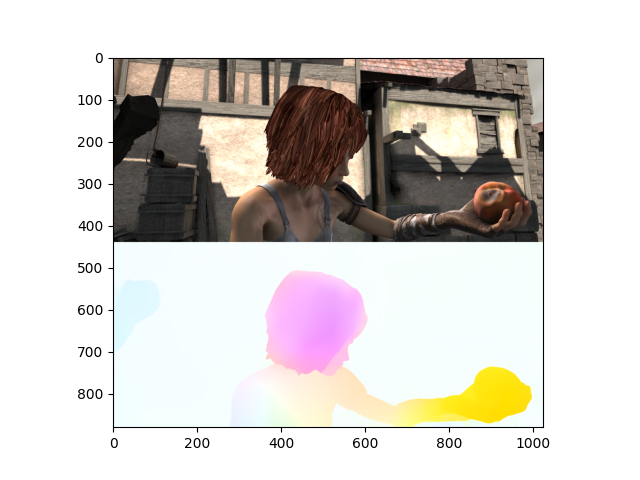

In [4]:
import sys
sys.path.append('core')

import argparse
import os
# import cv2
import glob
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder



# DEVICE = 'cuda' # Using GPU
DEVICE = 'cpu' # Using CPU

def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)


def viz(img, flo):
    img = img[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()

    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    img_flo = np.concatenate([img, flo], axis=0)

    # import matplotlib.pyplot as plt
    plt.imshow(img_flo / 255.0)
    plt.show()

    # cv2.imshow('image', img_flo[:, :, [2,1,0]]/255.0)
    # cv2.waitKey()

def demo(args):
    model = torch.nn.DataParallel(RAFT(args))
    # model.load_state_dict(torch.load(args.model)) using GPU
    model.load_state_dict(torch.load(args.model, map_location=torch.device('cpu'))) # Using CPU

    model = model.module
    model.to(DEVICE)
    model.eval()

    with torch.no_grad():
        images = glob.glob(os.path.join(args.path, '*.png')) + \
                 glob.glob(os.path.join(args.path, '*.jpg'))

        images = sorted(images)
        for imfile1, imfile2 in zip(images[:-1], images[1:]):
            image1 = load_image(imfile1)
            image2 = load_image(imfile2)

            padder = InputPadder(image1.shape)
            image1, image2 = padder.pad(image1, image2)

            flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
            viz(image1, flow_up)

# model='models/raft-things.pth', path='demo-frames', small=False, mixed_precision=False, alternate_corr=False

class Args(argparse.Namespace):
  model = 'models/raft-things.pth'
  path = 'demo-frames'
  small = False
  mixed_precision = False
  alternate_corr = False

args=Args()

demo(args)

In [ ]:
!python demo.py --model=models/raft-things.pth --path=demo-frames

/home/venv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)
